In [24]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
# 1. Cargar y preprocesar los datos
df = pd.read_csv("./Data/customer_shopping_data_newdata.csv", delimiter=';')
df.head()

,Factura,ID_Cliente,Categoría,Cantidad,Importe,Método de Pago,Fecha_Factura,Centro_Comercial,Canal,Género,Edad,Zona
0,I000001,C635512,Moda,4,2081.20,Otras Tarjetas,03/12/2022,Pozuelo,Web,Masculino,34,Centro
1,I000002,C974189,Libros,5,2355.45,Tarjeta ECI,21/03/2023,Diagonal,Web,Masculino,34,Sur
2,I000003,C352651,Supermercado,3,792.10,Efectivo,02/03/2020,Plaza Catalunya,Tienda física,Femenino,52,Centro
3,I000004,C360946,Moda,1,1859.29,Efectivo,24/08/2022,Princesa,Web,Femenino,61,Norte
4,I000005,C337093,Supermercado,5,105.99,Efectivo,09/08/2020,Princesa,Web,Femenino,58,Centro


In [20]:
#Al igual que hicimos en la fase inicial, vamos a agrupar los clientes y renombrar columnas
#Asegurar formatos, sobretodo para el campo fecha, vamos a asegurarnos que tiene el formato requerido
df['Fecha_Factura'] = pd.to_datetime(df['Fecha_Factura'], format="%d/%m/%Y")
df['Factura'] = df['Factura'].astype(str)
today = df['Fecha_Factura'].max()
df_new = df.groupby('ID_Cliente').agg({
    'Importe': ['sum', 'mean'],
    'Factura': 'count',
    'Fecha_Factura': lambda x: (today - x.max()).days,
    'Categoría': lambda x: x.mode()[0],
    'Canal': lambda x: x.mode()[0],
    'Edad': 'first',
    'Método de Pago': lambda x: x.mode()[0],
    'Género': 'first'
})
df_new.head()

Importe          Factura Fecha_Factura    Categoría  \
                sum     mean   count      <lambda>     <lambda>   
ID_Cliente                                                        
C100700       74.47    74.47       1           223    Souvenirs   
C101057     4529.89  4529.89       1           571         Moda   
C102144     3387.15  3387.15       1           202         Moda   
C102779     1765.32  1765.32       1           527  Electrónica   
C104233     2699.99  2699.99       1          1251   Juguetería   

                    Canal  Edad  Método de Pago     Género  
                 <lambda> first        <lambda>      first  
ID_Cliente                                                  
C100700               Web    44     Tarjeta ECI   Femenino  
C101057               Web    55     Tarjeta ECI   Femenino  
C102144     Tienda física    54  Otras Tarjetas  Masculino  
C102779               Web    59     Tarjeta ECI   Femenino  
C104233               Web    62     Tarjeta ECI  Masculino

In [21]:
df_new.columns = ['Importe_total', 'Ticket_medio', 'Frecuencia', 'Dias_desde_ultima_factura', 'Categoria_top', 'Canal_preferido', 'Edad', 'Metodo_pago', 'Genero']
df_new.reset_index(inplace=True)
df_new.head()

,ID_Cliente,Importe_total,Ticket_medio,Frecuencia,Dias_desde_ultima_factura,Categoria_top,Canal_preferido,Edad,Metodo_pago,Genero
0,C100700,74.47,74.47,1,223,Souvenirs,Web,44,Tarjeta ECI,Femenino
1,C101057,4529.89,4529.89,1,571,Moda,Web,55,Tarjeta ECI,Femenino
2,C102144,3387.15,3387.15,1,202,Moda,Tienda física,54,Otras Tarjetas,Masculino
3,C102779,1765.32,1765.32,1,527,Electrónica,Web,59,Tarjeta ECI,Femenino
4,C104233,2699.99,2699.99,1,1251,Juguetería,Web,62,Tarjeta ECI,Masculino


In [ ]:
features = ['Ticket_medio','Edad', 'Categoria_top', 'Genero']

# Cargar modelo y transformadores
knn = joblib.load('./Modelos/modelo_knn.pkl')
scaler = joblib.load('./Modelos/scaler.pkl')
pca = joblib.load('./Modelos/pca.pkl')

# Cargar LabelEncoders
label_encoders = {}
for col in ['Categoria_top', 'Genero']:
    label_encoders[col] = joblib.load(f'labelencoder_{col}.pkl')


# Aplicar LabelEncoding
for col in ['Categoria_top', 'Genero']:
    df_new[col] = label_encoders[col].transform(df_new[col])

# Escalar
X_new_scaled = scaler.transform(df_new[features])

# PCA (si lo usaste)
X_new_pca = pca.transform(X_new_scaled)

# Predecir
y_new_pred = knn.predict(X_new_pca)

print("Predicciones:", y_new_pred)

Predicciones: [0 1 1 1 1 3 3 1 1 1 0 1 1 0 1 1 3 2 0 1 1 0 3 1 0 3 1 1 3 1 1 1 1 3 1 1 3
 1 0 1 3 1 0 1 1 1 0 3 1 0 1 1 1 2 1 1 1 3 1 1 1 1 1 1 0 0 1 1 1 1 0 1 3 1
 3 3 1 1 1 1 1 1 0 1 1 1 3 1 0 1 1 1 0 0 0 0 0 1 1 0 1 2 1 1 1 1 3 1 0 1 1
 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 3 3 1 1 3 1 1 1 0 1 1 3 1 1 3 3 0
 1 1 1 1 1 1 0 0 3 1 3 1 1 0 3 2 1 0 1 1 1 1 1 1 3 1 0 3 0 0 1 1 0 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 3 0 1 1 1 1 0 0 0 0 1 3 1 1 0 1 1 1 1 1 0 3 1 0 1 1
 0 1 1 0 1 0 1 3 1 0 2 0 2 1 1 1 0 1 1 1 1 1 1 1 3 1 3 1 1 2 1 1 1 1 3 1 1
 1 1 1 3 1 1 0 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1 2 0 1 1 0 1 1 0 3 0 0 1
 1 1 1 1 1 0 1 3 1 0 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 0 1 3 1 1 1 1 1 1 1
 2 1 1 3 0 1 1 1 0 1 0 3 1 0 1 1 1 3 1 1 1 1 1 0 3 1 1 1 1 0 1 3 0 1 1 1 1
 0 1 1 1 1 0 3 0 1 1 0 0 3 2 1 1 2 2 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1
 0 1 1 3 1 2 1 1 1 1 2 1 3 1 1 1 0 1 2 1 1 3 1 1 3 2 1 1 3 1 1 3 3 1 1 1 0
 0 1 3 1 1 1 1 2 1 1 1 1 1 3 1 1 2 1 1 2 2 1 1 0 1 2 1 1 1 1 1 1 1 1 1 0 1
 3 0 0 1 1 

In [31]:

# Guardar el DataFrame actualizado
df_new.to_csv('./Data/customer_shopping_data_newdata_con_predicciones.csv', index=False, sep=';')

# Diccionario de etiquetas categóricas
cluster_labels = {
    0: 'Clientes Estrella',
    1: 'Compradores de Temporada',
    2: 'Cazadores de Ofertas',
    3: 'Curiosos o Ocasionales'
}
# Convertir a etiquetas descriptivas
df_new['Predicciones'] = [cluster_labels[p] for p in y_new_pred]



C:\Users\67672279\AppData\Local\Temp\ipykernel_4424\631928852.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(frecuencias.keys(), rotation=45, ha='right')


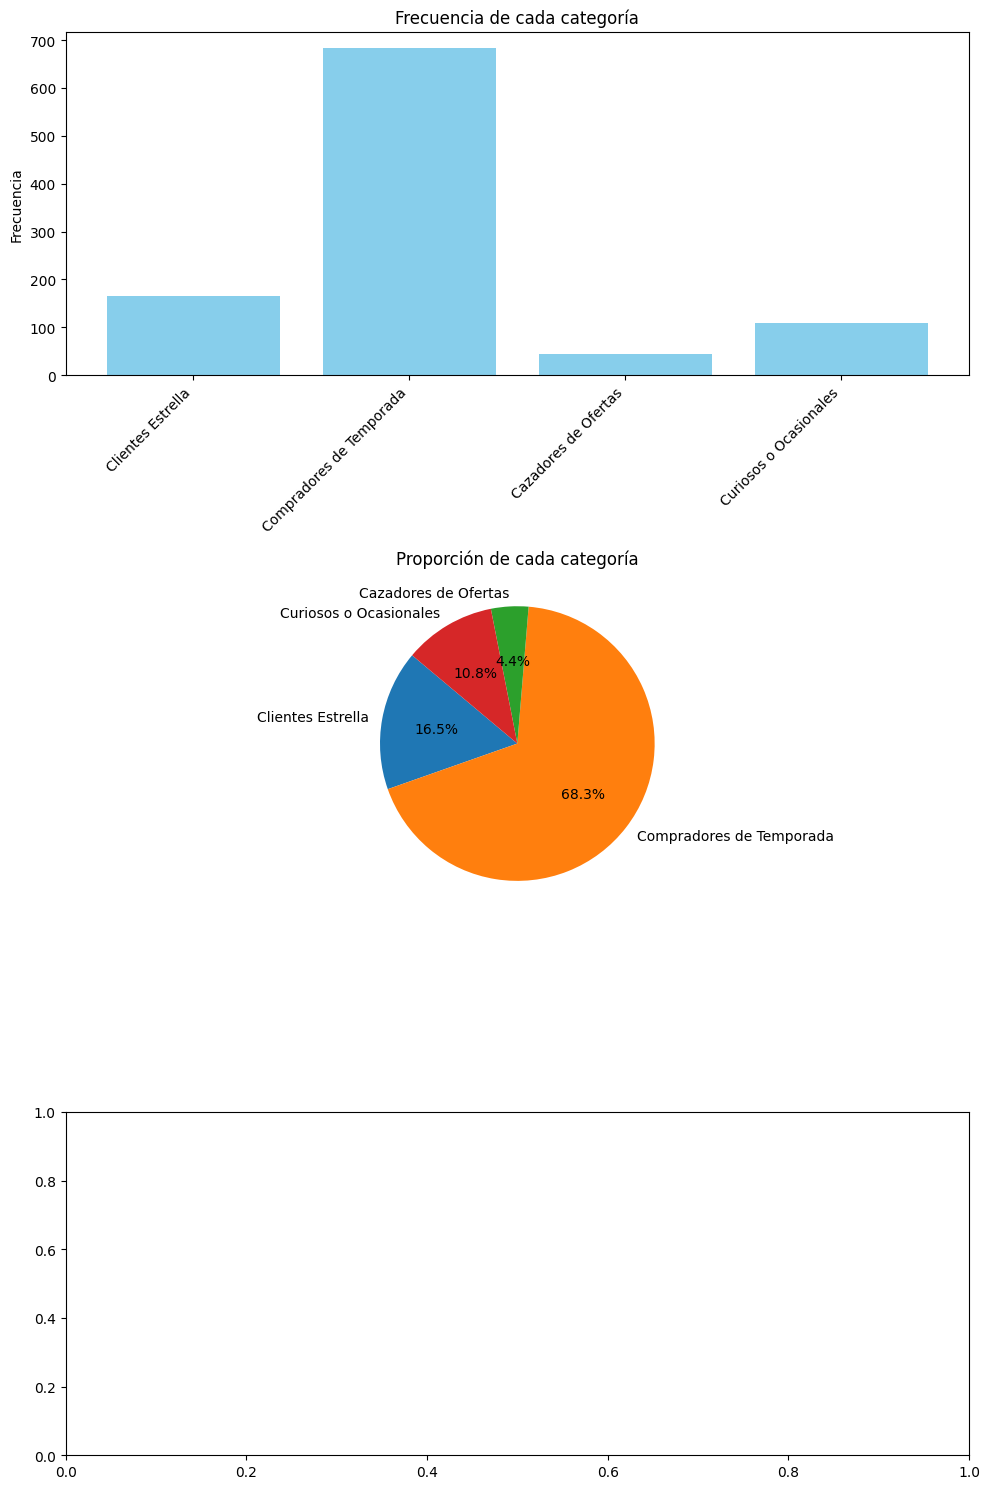

In [ ]:
#Vamos a verlo graficamente la predicción

# Convertir predicciones numéricas a etiquetas categóricas
predicciones_categoricas = [cluster_labels[pred] for pred in y_new_pred]

# Contar la frecuencia de cada categoría
frecuencias = {label: predicciones_categoricas.count(label) for label in cluster_labels.values()}

# Crear gráficos
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Gráfico de Barras
axs[0].bar(frecuencias.keys(), frecuencias.values(), color='skyblue')
axs[0].set_title('Frecuencia de cada categoría')
axs[0].set_ylabel('Frecuencia')
axs[0].set_xticklabels(frecuencias.keys(), rotation=45, ha='right')

# Gráfico de Pastel
axs[1].pie(frecuencias.values(), labels=frecuencias.keys(), autopct='%1.1f%%', startangle=140)
axs[1].set_title('Proporción de cada categoría')

# Ajustar diseño
plt.tight_layout()
plt.show()